/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Begin init data loader
Batch Size: 6.0 MiB
Data Size: 292.96875 GiB
Data Loader init time: 0.510867 s
Begin init fetcher
Fetcher init time: 0.579564 s
Begin init data loader
Batch Size: 24.0 MiB
Data Size: 234.375 GiB
Data Loader init time: 1.336738 s
Begin init fetcher
Fetcher init time: 1.362360 s
Model: VggNet CIFAR100 NO DO
--------------------------------------------------
Num Params: 56318948
Training VggNet

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   |  Validation Time   |  GPU Memory (GiB)  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       

/home/jaskin/Intro_Deep_Learning/HM2/jlib/classifier.py:235: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_pred = torch.tensor(Y_pred_eval)


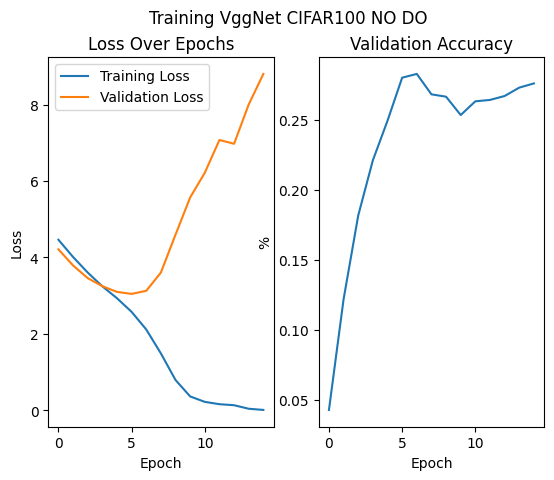

Begin init data loader
Batch Size: 6.0 MiB
Data Size: 292.96875 GiB
Data Loader init time: 0.891587 s
Begin init fetcher
Fetcher init time: 0.971668 s
Begin init data loader
Batch Size: 24.0 MiB
Data Size: 234.375 GiB
Data Loader init time: 2.907396 s
Begin init fetcher
Fetcher init time: 2.985608 s
Model: VggNet CIFAR10 DO
--------------------------------------------------
Num Params: 56134538
Training VggNet

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   |  Validation Time   |  GPU Memory (GiB)  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0 

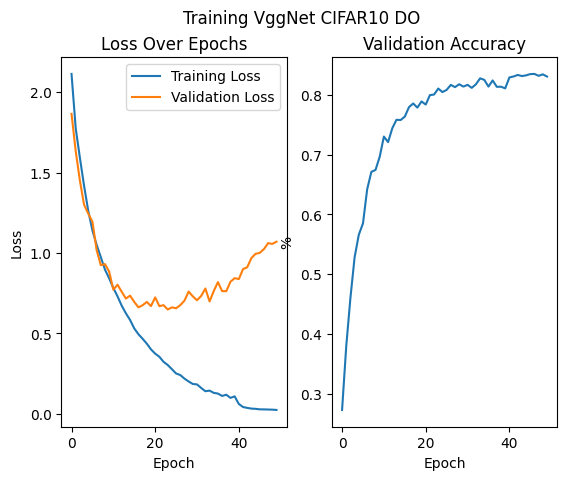

Model: VggNet CIFAR10 NO DO
--------------------------------------------------
Num Params: 56134538
Training VggNet

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   |  Validation Time   |  GPU Memory (GiB)  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |     123.707168     |      2.025775      |      1.755676      |     -13.333106     |     34.450000      |      0.000000      |     73.099283      |     11.327667      |
-----------------------------------------------------------------------------------------------------------------------

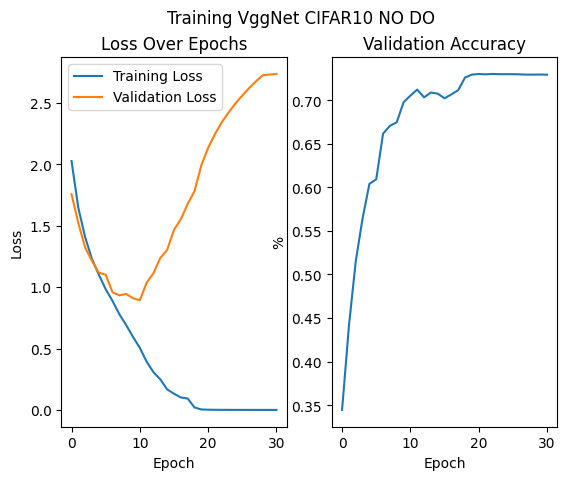

In [1]:
import os
#from helpers import *

from jlib.cifar_preprocessing import get_cifar_loaders, delete_deletables
from jlib.classifier import Classifier
from jlib.vggnet import VggNet, VggBlock, ConvParams
import torch
from torch import nn
import matplotlib.pyplot as plt
device = 'cuda'

"""
sudo fuser -v -k /usr/lib/wsl/drivers/nvhm.inf_amd64_5c197d2d97068bef/*
"""
    




def train_and_plot(model: Classifier, train, val, title, min_accuracy=0.65):
    print(f"Model: {title}")
    print("-"*50)
    print(f"Num Params: {sum(p.numel() for p in model.parameters())}")
    model.train_model(
        epochs=50,
        train_loader=train,
        val_loader=val,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam,
        optimizer_args=[],
        optimizer_kwargs={'lr': 1e-4 },
        print_epoch=1,
        header_epoch=10,
        sched_factor=0.1,
        sched_patience=5,
        min_accuracy = 1,
        max_negative_diff_count = 7
    )
    torch.save(model, f'models/{title}.pth')
    fig = model.plot_training(f"Training {title}")
    fig.savefig(f'figures/{title}.png')
    plt.show()
    #plt.savefig(f'figures/{title}.png')

# Num Params original vgg-16 is 3.375870e+08
architecture = {
    'in_chan': 3,
    'in_dim': (32, 32),
    'block_params': [
        VggBlock(
            params=ConvParams(kernel=3,out_chan=256),
            pool_kernel=2,
            pool_stride=2,
            repititions=2
        ),
        VggBlock(
            params=ConvParams(kernel=3,out_chan=512),
            pool_kernel=2,
            pool_stride=1,
            repititions=2
        ),
        VggBlock(
            params=ConvParams(kernel=3,out_chan=512),
            pool_kernel=2,
            pool_stride=1,
            repititions=3
        ),
        VggBlock(
            params=ConvParams(kernel=3,out_chan=256),
            pool_kernel=2,
            pool_stride=1,
            repititions=3
        ),
        VggBlock(
            params=ConvParams(kernel=3,out_chan=128),
            pool_kernel=2,
            pool_stride=1,
            repititions=3
        ),
    ],
    'fc_params': [
        2048,
        2048,
    ],
}
torch.cuda.empty_cache()
Vgg_100_dp = VggNet(
    num_classes=100,
    dropout = 0.5,
    **architecture
).to(device)


cifar_100_train_loader, cifar_100_val_loader = get_cifar_loaders(
    is_cifar10=False,
    train_batch_size=512,
    val_batch_size=2048,
    train_workers=6,
    train_cpu_prefetch=10,
    train_gpu_prefetch=10,
    val_workers=2,
    val_cpu_prefetch=2,
    val_gpu_prefetch=2,
)




train_and_plot(Vgg_100_dp, cifar_100_train_loader, cifar_100_val_loader, "VggNet CIFAR100 DO")
delete_deletables([Vgg_100_dp])


torch.cuda.empty_cache()
Vgg_100_ndp = VggNet(
    num_classes=100,
    dropout = 0,
    **architecture
).to(device)

train_and_plot(Vgg_100_ndp, cifar_100_train_loader, cifar_100_val_loader, "VggNet CIFAR100 NO DO")
delete_deletables([Vgg_100_ndp])

delete_deletables([cifar_100_train_loader, cifar_100_val_loader])

cifar_10_train_loader, cifar_10_val_loader = get_cifar_loaders(
    is_cifar10=True,
    train_batch_size=512,
    val_batch_size=2048,
    train_workers=6,
    train_cpu_prefetch=10,
    train_gpu_prefetch=10,
    val_workers=2,
    val_cpu_prefetch=2,
    val_gpu_prefetch=2,
)


torch.cuda.empty_cache()
Vgg_10_dp = VggNet(
    num_classes=10,
    dropout = 0.5,
    **architecture
).to(device)

train_and_plot(Vgg_10_dp, cifar_10_train_loader, cifar_10_val_loader, "VggNet CIFAR10 DO")
delete_deletables([Vgg_10_dp])

torch.cuda.empty_cache()
Vgg_10_ndp = VggNet(
    num_classes=10,
    dropout = 0,
    **architecture
).to(device)

train_and_plot(Vgg_10_ndp, cifar_10_train_loader, cifar_10_val_loader, "VggNet CIFAR10 NO DO")
del Vgg_10_ndp


